# Bank Personal Loan Analysis

### Author: Jorge Montoya
### Domain: Finance
### Timeframe: Academic Project (Northeastern University)
### Date: December 2022
### Last Revision Date: January 2025
### Project Description:
##### This project looks to identify what are the risk factors for cancer mortality based on county level data from US by using machine learning algorithms.
#### Notes:
##### Last revision was made to add header information in this file prior to uploading to Github.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import matplotlib.image as plting
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import math

## Data Sourcing

In [ ]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name = 'Data')
df.head()

### Data Cleaning

In [ ]:
# Take out rows with elements negative experience and 4 digit zip code
df.drop(df[(df['ZIP Code'] ==9307)].index, inplace=True)
df.drop(df[(df['Experience'] <0)].index, inplace=True)

## Exploratory Data Analysis

In [ ]:
# No nulls
df.isnull().sum()

In [ ]:
# Information about the dataset - all integers/floats
df.info()

In [ ]:
# Descriptive statistics about dataset
df.describe()

In [ ]:
df.min()
#df.max()

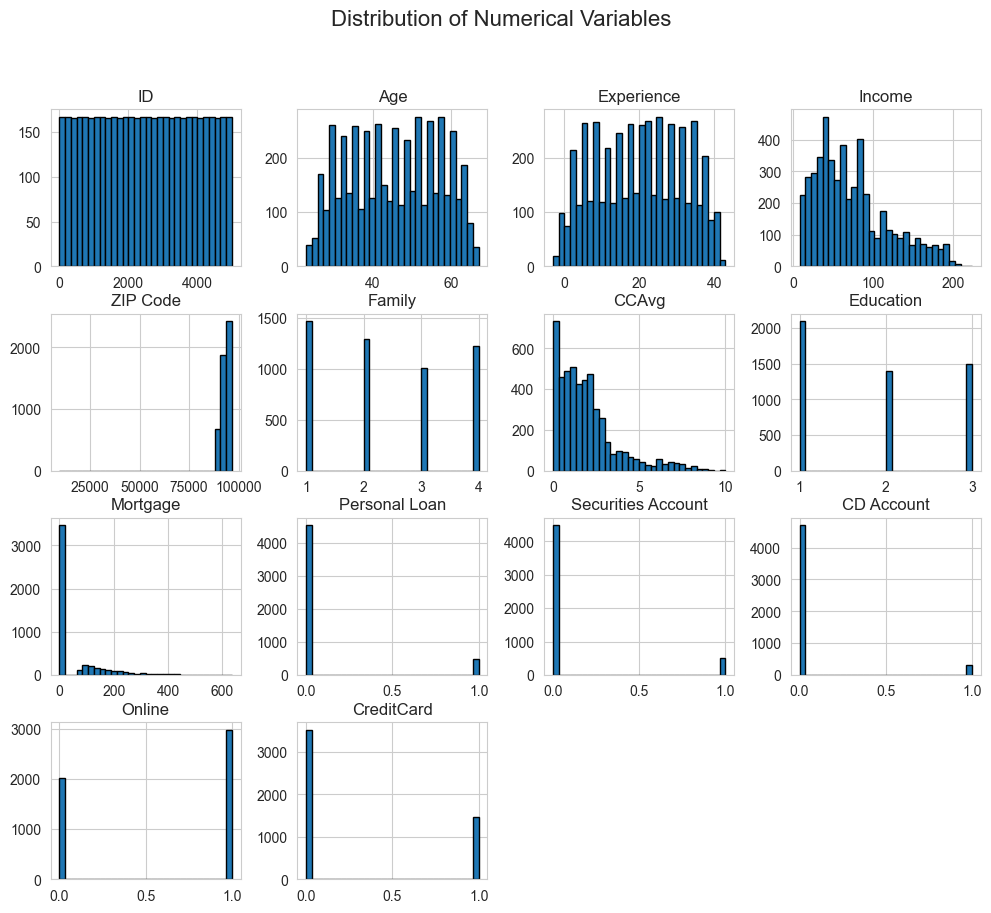

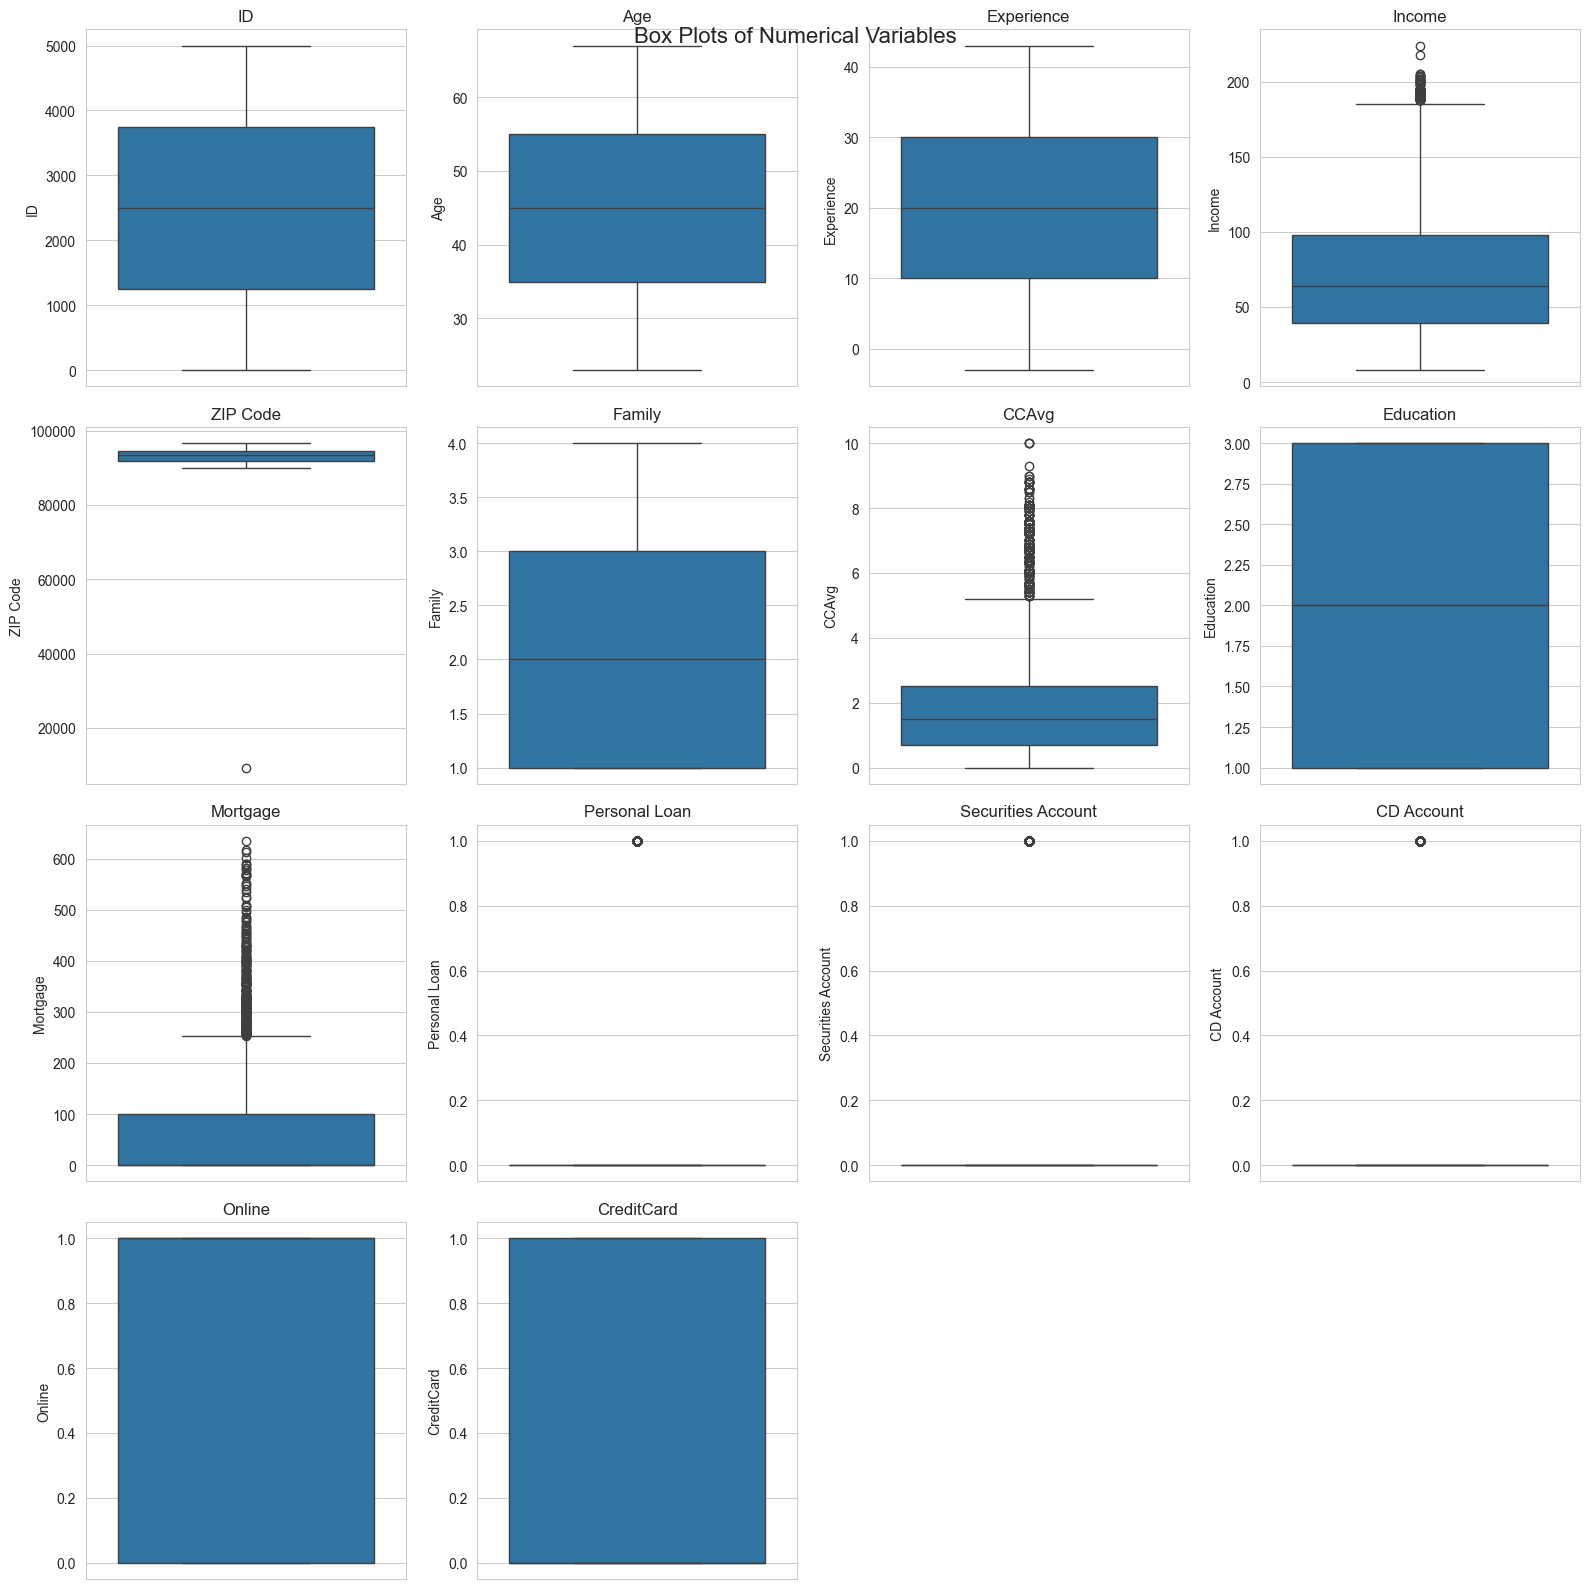

In [ ]:
# Set plot style
sns.set_style("whitegrid")

# Generate histograms and KDE plots for numerical variables
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Plot histograms
df_numeric.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of Numerical Variables', fontsize=16)
plt.show()

# Determine the number of subplots dynamically
num_vars = len(df_numeric.columns)
num_cols = 4  # Set number of columns
num_rows = math.ceil(num_vars / num_cols)

plt.figure(figsize=(16, 4 * num_rows))

for i, column in enumerate(df_numeric.columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(y=df_numeric[column])
    plt.title(column)

plt.tight_layout()
plt.suptitle('Box Plots of Numerical Variables', fontsize=16)
plt.show()



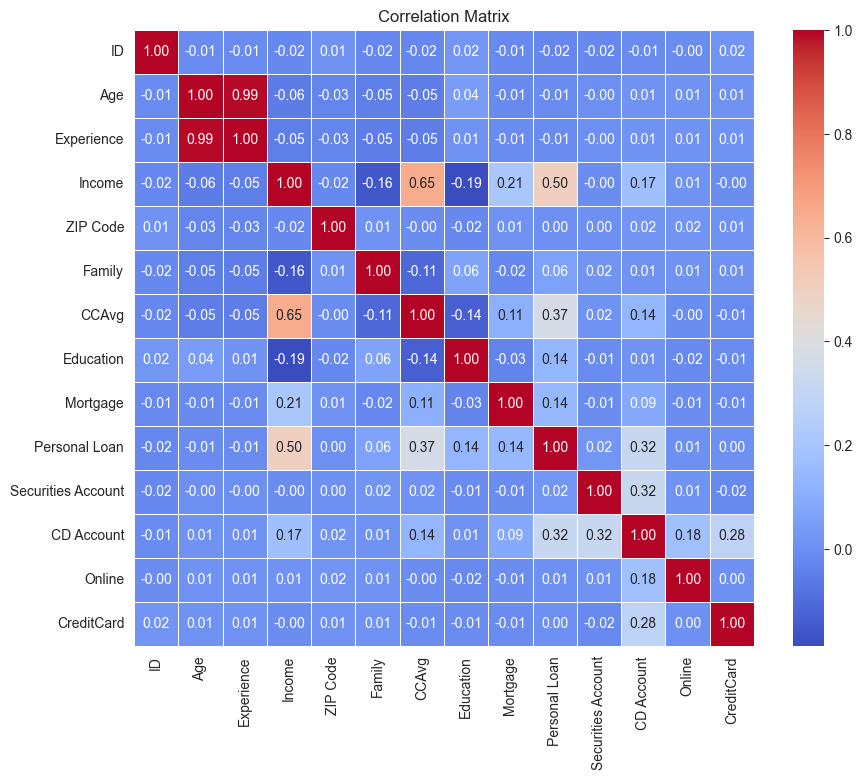

In [13]:
# Perform correlation analysis to identify relationships between variables
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


## Descriptive Analysis

In [18]:
from scipy.stats import ttest_ind

# Split data into groups based on loan approval status
loan_approved = df[df['Personal Loan'] == 1]
loan_not_approved = df[df['Personal Loan'] == 0]

# Perform t-tests on key numerical variables
t_test_results = {}
for column in ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']:
    t_stat, p_value = ttest_ind(loan_approved[column], loan_not_approved[column], equal_var=False)
    t_test_results[column] = {'t_statistic': t_stat, 'p_value': p_value}

# Convert results to a DataFrame for better visualization
t_test_results_df = pd.DataFrame(t_test_results).T
t_test_results_df

# Clear differences between age, experience, income, credit card spend and mortgage indication for the people that were approved for a bank loan vs not approved.

,t_statistic,p_value
Age,-0.540832,5.888297e-01
Experience,-0.519491,6.036157e-01
Income,50.233334,1.330735e-227
CCAvg,22.085230,2.148596e-77
Mortgage,6.568699,1.248005e-10


In [24]:
from scipy.stats import chi2_contingency

# Selecting binary variables for chi-square tests
binary_columns = ['Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'Education']

# Prepare chi-square test results
chi_square_results = []

for col in binary_columns[1:]:  # Exclude 'Personal Loan' as it's the target variable
    contingency_table = pd.crosstab(df['Personal Loan'], df[col])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append({
        'Variable': col,
        'Chi2 Statistic': chi2_stat,
        'P-Value': p_val
    })

# Convert results to DataFrame
chi_square_results_df = pd.DataFrame(chi_square_results)

chi_square_results_df

,Variable,Chi2 Statistic,P-Value
0,Securities Account,2.172311,1.405150e-01
1,CD Account,495.904242,7.398298e-110
2,Online,0.156007,6.928600e-01
3,CreditCard,0.021144,8.843861e-01
4,Education,111.239872,6.991474e-25


### Hypothesis testing 
#### These are simulated scenarios that will compare 2 groups (AB testing or split testing)

In [20]:
# Applying an example A/B test: Loan Offer Personalization Experiment
# Hypothesis: Customers with personalized loan offers (based on income) have higher acceptance rates.

# Define the groups
df['Offer_Type'] = df['Income'].apply(lambda x: 'Personalized' if x > df['Income'].median() else 'Standard')

# Perform statistical testing between the two groups
personalized_group = df[df['Offer_Type'] == 'Personalized']['Personal Loan']
standard_group = df[df['Offer_Type'] == 'Standard']['Personal Loan']

# Perform a t-test
t_stat, p_value = ttest_ind(personalized_group, standard_group, equal_var=False)

# Summarize the findings
ab_test_results = pd.DataFrame({
    'Group': ['Personalized', 'Standard'],
    'Loan Acceptance Rate': [personalized_group.mean(), standard_group.mean()],
    'Sample Size': [len(personalized_group), len(standard_group)]
})

ab_test_results['P-Value'] = p_value
ab_test_results


,Group,Loan Acceptance Rate,Sample Size,P-Value
0,Personalized,0.195102,2450,2.289808e-116
1,Standard,0.000784,2550,2.289808e-116


## Advanced Analytics
### This analysis is a classification problem because the goal is to help decide whether a customer will accept or reject a personal loan based on various factors. In classification problems, the target variable (also known as the dependent variable) consists of discrete categories or classes. In this case, the target variable is a binary variables "Personal Loan":

### 1 (Loan Accepted) – The customer accepted the loan in the last campaign.
### 0 (Loan Not Accepted) – The customer did not accept the loan in the last campaign (or was not offered one). 

### Preprocessing

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare the data for regression analysis
X = df.drop(columns=['Personal Loan','Offer_Type'])
y = df['Personal Loan']

# Convert categorical variables if necessary (e.g., Education)
X = pd.get_dummies(X, columns=['Education'], drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Processing

In [30]:
# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
result = model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, conf_matrix, classification_rep


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9433333333333334,
 array([[1345,   25],
        [  60,   70]]),
 '              precision    recall  f1-score   support\n\n           0       0.96      0.98      0.97      1370\n           1       0.74      0.54      0.62       130\n\n    accuracy                           0.94      1500\n   macro avg       0.85      0.76      0.80      1500\nweighted avg       0.94      0.94      0.94      1500\n')

In [33]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Evaluate models
rf_accuracy = accuracy_score(y_test, rf_pred)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Create a summary of model performance
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_accuracy, xgb_accuracy],
    'AUC Score': [rf_auc, xgb_auc]
})
model_comparison


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [19:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,AUC Score
0,Random Forest,0.982000,0.995446
1,XGBoost,0.982667,0.995716


In [37]:
def automate_model_evaluation(data, target_column, test_size=0.3, random_state=42, xgb_params=None):
    # Load the dataset
    df = data
    
    # Prepare features and target
    X = df.drop(columns=[target_column, 'Offer_Type'])
    y = df[target_column]
    X = pd.get_dummies(X, columns=['Education'], drop_first=True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    }
    
    if xgb_params:
        models['XGBoost'].set_params(**xgb_params)
    
    results = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'AUC Score': auc_score,
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1-Score': report['1']['f1-score']
        })
    
    results_df = pd.DataFrame(results)
    
    # Plot evaluation metrics
    plt.figure(figsize=(10, 6))
    results_df.set_index('Model').plot(kind='bar', ax=plt.gca())
    plt.title('Model Evaluation Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return results_df

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [19:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings

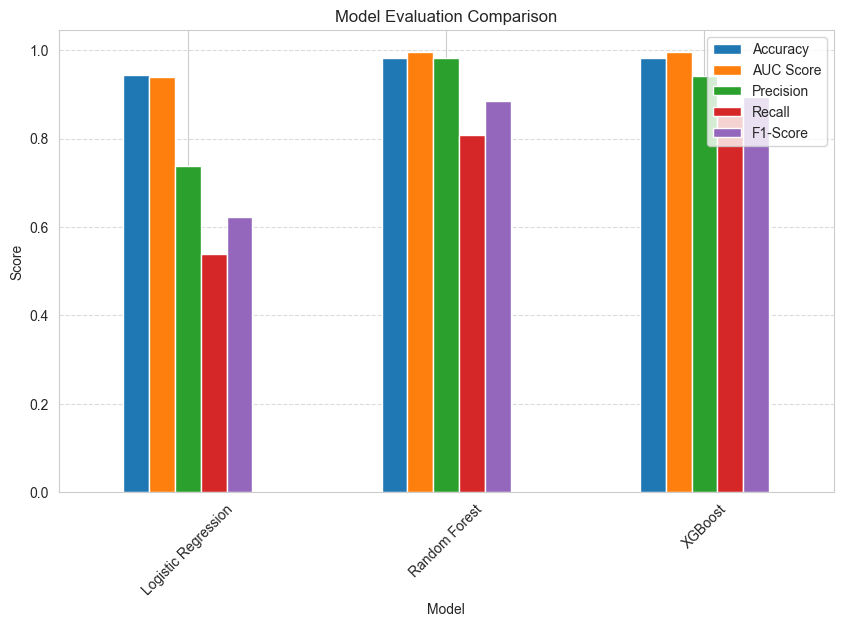

,Model,Accuracy,AUC Score,Precision,Recall,F1-Score
0,Logistic Regression,0.943333,0.940028,0.736842,0.538462,0.622222
1,Random Forest,0.982000,0.995446,0.981308,0.807692,0.886076
2,XGBoost,0.982667,0.995716,0.940678,0.853846,0.895161


In [39]:
# Apply the automated function to the provided dataset
results_df = automate_model_evaluation(df, 'Personal Loan')
results_df

### Feature Importance / Odds Ratio Analysis

In [36]:
# Evaluate feature importance using coefficients from logistic regression
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Odds': np.exp(model.coef_[0])
}).sort_values(by='Odds', ascending=False)

feature_importance


,Feature,Odds
13,Education_3,15.664365
9,CD Account,12.366965
12,Education_2,9.209772
5,Family,2.269909
8,Securities Account,1.829987
2,Experience,1.588864
6,CCAvg,1.089753
3,Income,1.056586
7,Mortgage,1.001049
0,ID,1.000022
